<h2> 모델 import</h2>

In [3]:
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

processor = SegformerImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = AutoModelForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")

/Users/ihoyeol/anaconda3/lib/python3.11/site-packages/transformers/models/segformer/image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


<h2>의류 분리</h2>

In [4]:
success = 0
fail = 0
crop_file = 1
crop_image_dir_list= []

image_files = glob.glob('./image/*.jpg') + glob.glob('./image/*.png') + glob.glob('./image/*.jpeg')

for image_path in image_files:
    try:
        file_name = os.path.basename(image_path)
        image_name, extension = os.path.splitext(file_name)
        # 크롭된 이미지를 저장할 디렉토리 이름
        crop_dir_name = "./crop_images/" + image_name + "/"
        if not os.path.exists(crop_dir_name):
            os.mkdir(crop_dir_name)
        crop_image_dir_list.append(crop_dir_name)

        # PIL 라이브러리를 사용하여 이미지 열기
        image = Image.open(image_path)
        
        if image.mode == 'RGBA':
            image = image.convert('RGB')

        inputs = processor(images=image, return_tensors="pt")

        outputs = model(**inputs)
        logits = outputs.logits.cpu()

        upsampled_logits = nn.functional.interpolate(
            logits,
            size=image.size[::-1],
            mode="bilinear",
            align_corners=False,
        )

        pred_seg = upsampled_logits.argmax(dim=1)[0]

        category_mapping = {
            1: "Hat",   
            4: "Upper-clothes", 
            5: "Skirt", 
            6: "Pants", 
            7: "Dress", 
            16: "Bag", 
            17: "Scarf"
        }

        unique_classes = np.unique(pred_seg.numpy())

        for class_id in unique_classes:
            category_name = category_mapping.get(class_id, 'Unknown')
            if category_name != 'Unknown':  # 'Unknown' 카테고리는 무시
                class_mask = (pred_seg == class_id).numpy().astype(np.uint8)

                # 배경이 하얀색인 3채널 이미지 생성
                background_color = [125, 125, 125]  # 하얀색 배경
                background_image = np.ones_like(np.array(image)) * background_color
                
                # 마스크를 이용하여 배경과 객체 영역을 합성
                class_mask_rgb = np.repeat(class_mask[:, :, np.newaxis], 3, axis=2)
                segmented_image = np.where(class_mask_rgb, np.array(image), background_image)

                segmented_image_pil = Image.fromarray(segmented_image.astype(np.uint8))

                nonzero_px = np.argwhere(class_mask)
                if nonzero_px.size == 0:
                    continue
                top_left = np.min(nonzero_px, axis=0)
                bottom_right = np.max(nonzero_px, axis=0)
                crop_box = (top_left[1], top_left[0], bottom_right[1] + 1, bottom_right[0] + 1)

                cropped_segmented_image = segmented_image_pil.crop(crop_box)

                scaled_size = (cropped_segmented_image.width * 2, cropped_segmented_image.height * 2)
                cropped_segmented_image = cropped_segmented_image.resize(scaled_size, Image.ANTIALIAS)

                save_path = f"{crop_dir_name}{category_name.replace(' ', '_')}_class_{class_id}.png"
                cropped_segmented_image.save(save_path)
                print(f"Saved {category_name} image to {save_path}")
        crop_file += 1
        success += 1

    except Exception as e:
        print("실행 중 오류 발생:", e)
        fail += 1

print("성공 : " + str(success) + ", 실패 : " + str(fail))
print("총 생성된 crop_image : " + str(crop_file - 1))

/var/folders/14/fstt0hn95t16v5n40z90k__w0000gn/T/ipykernel_8837/4263863024.py:75: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  cropped_segmented_image = cropped_segmented_image.resize(scaled_size, Image.ANTIALIAS)


Saved Upper-clothes image to ./crop_images/hoyeol(3.23)_13/Upper-clothes_class_4.png
Saved Pants image to ./crop_images/hoyeol(3.23)_13/Pants_class_6.png
Saved Bag image to ./crop_images/hoyeol(3.23)_13/Bag_class_16.png
Saved Upper-clothes image to ./crop_images/hoyeol(3.23)_20/Upper-clothes_class_4.png
Saved Pants image to ./crop_images/hoyeol(3.23)_20/Pants_class_6.png
Saved Bag image to ./crop_images/hoyeol(3.23)_20/Bag_class_16.png
Saved Upper-clothes image to ./crop_images/hoyeol(3.23)_14/Upper-clothes_class_4.png
Saved Pants image to ./crop_images/hoyeol(3.23)_14/Pants_class_6.png
성공 : 3, 실패 : 0
총 생성된 crop_image : 3


<h2>이미지 출력</h2>

./image/hoyeol(3.23)_13.jpg


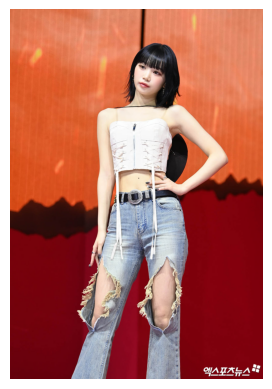

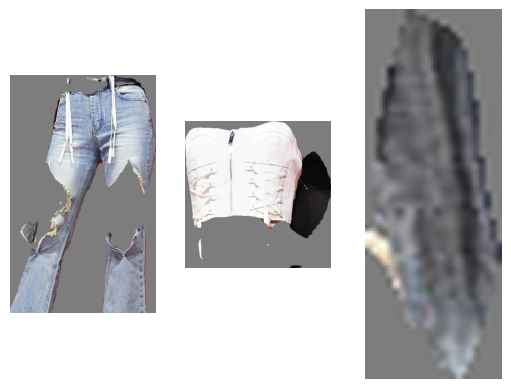

---------------------------------------------------------------------
./image/hoyeol(3.23)_20.jpg


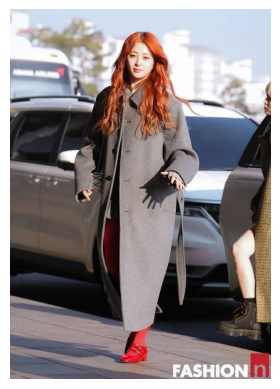

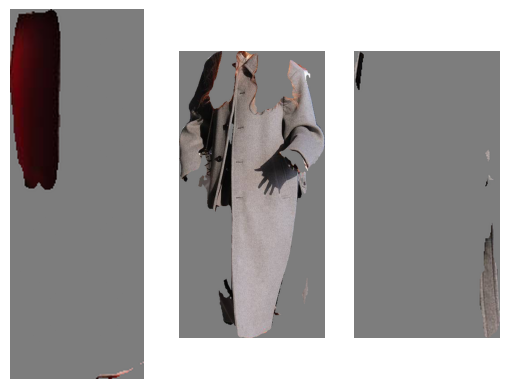

---------------------------------------------------------------------
./image/hoyeol(3.23)_14.jpeg


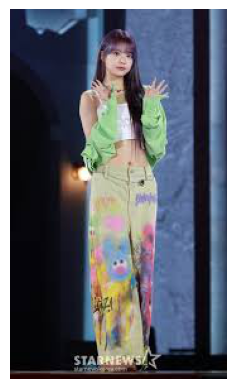

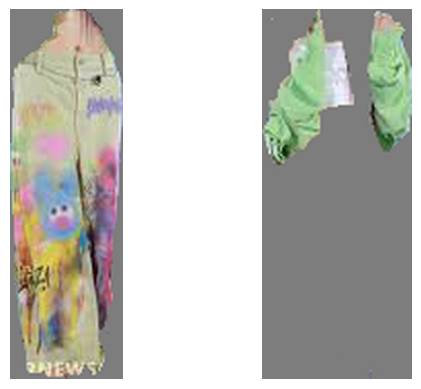

---------------------------------------------------------------------


In [5]:
crop_image_adr = []
for i in crop_image_dir_list:
    crop_image_adr.append(glob.glob(i + '*.jpg') + glob.glob(i + '*.png') + glob.glob(i + '*.jpeg'))

def image_prints(file_path):
    # 이미지 개수(n)에 따라 동적으로 서브플롯을 생성합니다.
    fig, axes = plt.subplots(1, len(file_path))

    # 한 개의 이미지만 있는 경우, axes 배열이 아니라 단일 객체가 됩니다.
    # 이 경우를 처리하기 위해 axes 객체를 배열로 변환합니다.
    if len(file_path) == 1:
        axes = [axes]

    # 각 이미지에 대해 반복 처리합니다.
    for ax, img_path in zip(axes, file_path):
        img = mpimg.imread(img_path) # 이미지를 로드합니다.
        ax.imshow(img)               # 이미지를 표시합니다.
        ax.axis('off')               # 이미지 주변의 축을 제거합니다.

    plt.show()

def image_print(image_path):
    img = mpimg.imread(image_path)

    # 이미지를 표시합니다.
    plt.imshow(img)
    plt.axis('off') # 이미지 주변의 축을 제거합니다.
    plt.show()
    
    
j = 0
for i in image_files:
    print(i)
    image_print(i)
    image_prints(crop_image_adr[j])
    print("---------------------------------------------------------------------")
    j += 1

<h2>crop 폴더 전체 삭제</h2>

In [2]:
import glob
import shutil

# 삭제할 폴더 패턴 설정
folder_pattern = './crop_images/*'

# 지정된 패턴에 일치하는 모든 폴더 찾기
folders = glob.glob(folder_pattern)

# 찾은 폴더들을 반복하여 삭제
for folder in folders:
    # 폴더 삭제
    shutil.rmtree(folder)
    print(f'{folder} 폴더가 삭제되었습니다.')

./crop_images/hoyeol(3.23)_15 폴더가 삭제되었습니다.
./crop_images/hoyeol(3.23)_13 폴더가 삭제되었습니다.
